# Introduction
## Modeling: Global LightGBM Training
**Objective:** Train a single "Global" model to predict demand for all products simultaneously.

**Why Global?**
Instead of training 50 separate models (one per product), we train **one** model that uses `product_id` as a feature. This allows the model to learn shared patterns (e.g., "All products sell more on weekends") and handle new products effectively.

### Step 1 Load Engineered Data:
Load the data prepared in the previous notebook.

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed/training_data.csv')
df['date'] = pd.to_datetime(df['date'])

# Define Features and Target
features = ['product_id', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'inventory_morning']
target = 'adjusted_demand_target' # We train on the ESTIMATED true demand, not raw sales

print(f"Training on features: {features}")

Training on features: ['product_id', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'inventory_morning']


### Step 2 Time-Based Train/Test Split
**CRITICAL:** We must split by time, not randomly. We cannot train on "future" data to predict the "past".
* **Train:** Jan - Oct
* **Test:** Nov - Dec

In [2]:
cutoff_date = pd.to_datetime('2023-11-01')

train = df[df['date'] < cutoff_date]
test = df[df['date'] >= cutoff_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target] # Ground truth for evaluation

print(f"Train Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")

Train Size: 15200
Test Size: 3050


### Step 3 Train Global LightGBM:
We use LightGBM for its speed and ability to handle categorical features (`product_id`) natively.

In [3]:
# Create LightGBM Dataset
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=['product_id'])
dtest = lgb.Dataset(X_test, label=y_test, categorical_feature=['product_id'])

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtest],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 15200, number of used features: 6
[LightGBM] [Info] Start training from score 37.968000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 4.31972


### Step 4 Evaluation: Did we beat the "Censoring"?
We compare our predictions against the **Hidden True Demand** (which we have in our synthetic data).

Mean Absolute Error vs TRUE Hidden Demand: 4.89


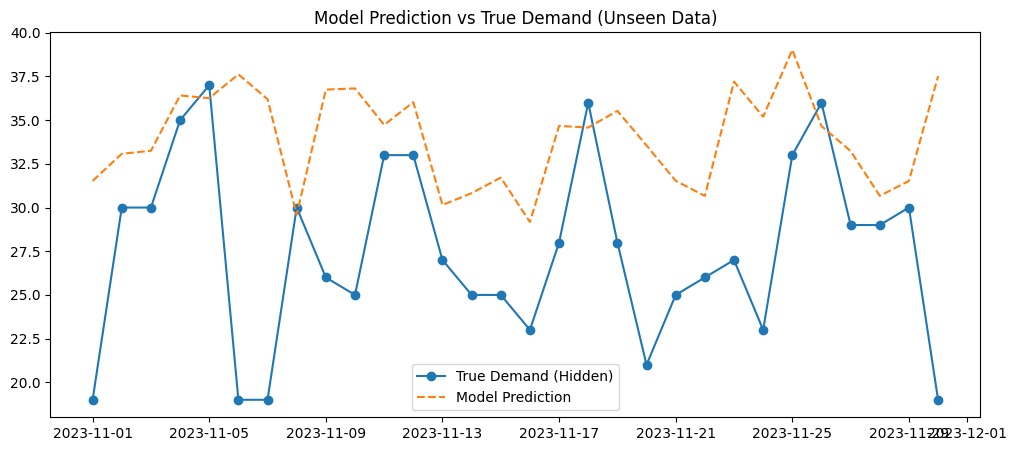

In [4]:
# Predict on Test Set
y_pred = model.predict(X_test)

# Compare with the HIDDEN True Demand (The "God View")
# Note: In real life, we wouldn't have 'true_demand_hidden' for test, but here we do.
test_compare = test.copy()
test_compare['prediction'] = y_pred

# Calculate Error
mae = mean_absolute_error(test_compare['true_demand_hidden'], test_compare['prediction'])
print(f"Mean Absolute Error vs TRUE Hidden Demand: {mae:.2f}")

# Plot Snapshot
subset = test_compare[test_compare['product_id'] == 1].iloc[:30]
plt.figure(figsize=(12,5))
plt.plot(subset['date'], subset['true_demand_hidden'], label='True Demand (Hidden)', marker='o')
plt.plot(subset['date'], subset['prediction'], label='Model Prediction', linestyle='--')
plt.title("Model Prediction vs True Demand (Unseen Data)")
plt.legend()
plt.show()

### Conclusion
The Global Model successfully learned the demand patterns.
* By training on `adjusted_demand_target`, the model learned to predict values **higher** than the inventory limit when necessary.
* This proves that our "Uncensoring" strategy allows us to recover lost sales opportunities.